# Phishing Mail Detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

In [2]:
data = pd.read_csv("/kaggle/input/phishingemails/Phishing_Email.csv")
print("Shape", data.shape)
data.head()

Shape (18650, 3)


,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


## Data Ratio

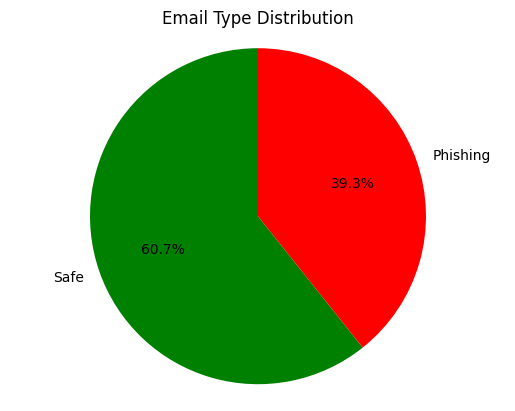

In [3]:
count = data["Email Type"].count()

safe_ratio = data["Email Type"].value_counts()["Safe Email"] / count
phishing_ratio = data["Email Type"].value_counts()["Phishing Email"] / count

plt.pie([safe_ratio, phishing_ratio], 
        labels=['Safe', 'Phishing'], 
        colors=["green", "red"],
        autopct='%1.1f%%', 
        startangle=90)
plt.title('Email Type Distribution')
plt.axis('equal')
plt.show()

## Remove Missing Values

In [4]:
data.isnull().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

Data contains 16 missings. Remove the missing values.

In [6]:
data = data.dropna()

In [7]:
data.isnull().sum()

Unnamed: 0    0
Email Text    0
Email Type    0
dtype: int64

In [8]:
# Remove index column
data = data.drop("Unnamed: 0", axis=1)

## Preprocessing

1. Case folding all text: Conversion to lowercase,
2. Data cleaning by removing unnecessary characters
3. Stopwords removal
4. Stemming: reduced words to their root forms
5. Feature Extraction: TF-IDF
6. Label Encoding


In [9]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

stemmer = PorterStemmer()

def casefolding(text):
    return text.lower()

def remove_unnecessary_char(text):
    # Remove email headers and metadata
    text = re.sub(r'^.*?subject:\s*', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\b(?:from|to|cc|bcc|sent|date):.*?\n', ' ', text, flags=re.IGNORECASE)

    text = re.sub(r'<.*?>', ' ', text) # Remove HTML tags if present
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) # Remove nonalphanumeric
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', ' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def tokenizing(text):
    text = word_tokenize(text)
    return text
    
def remove_stopwords(text):
    list_stopwords = stopwords.words('english')
    text = ' '.join(['' if word in list_stopwords else word for word in text])

    text = re.sub('  +', ' ', text)
    text = text.strip()
    return text

def stemming(text):
    stemmed_words = []

    for word in text.split(' '):
        stemmed_words.append(stemmer.stem(word))

    return ' '.join(stemmed_words)

def preprocess(data):
    data["Email Text"] = data['Email Text'].apply(casefolding)
    print(f"\nCasefolding Result: ")
    print(data.head())
    
    data["Email Text"] = data['Email Text'].apply(remove_unnecessary_char)
    print(f"\nRemove Unnecessary Character Result: ")
    print(data.head())

    data['Email Text'] = data['Email Text'].apply(tokenizing)
    print(f"\nTokenization Result: ")
    print(data.head())

    data['Email Text'] = data['Email Text'].apply(remove_stopwords)
    print(f"\nStopwords Removal Result: ")
    print(data.head())

    data['Email Text'] = data['Email Text'].apply(stemming)
    print(f"\nStemming Result: ")
    print(data.head())

    return data["Email Text"]

data['Email Text'] = preprocess(data)
data.to_csv('Preprocessed_Phishing_Email.csv', index=False)

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>



Casefolding Result: 
                                          Email Text      Email Type
0  re : 6 . 1100 , disc : uniformitarianism , re ...      Safe Email
1  the other side of * galicismos * * galicismo *...      Safe Email
2  re : equistar deal tickets are you still avail...      Safe Email
3  \nhello i am your hot lil horny toy.\n    i am...  Phishing Email
4  software at incredibly low prices ( 86 % lower...  Phishing Email

Remove Unnecessary Character Result: 
                                          Email Text      Email Type
0  re 6 1100 disc uniformitarianism re 1086 sex l...      Safe Email
1  the other side of galicismos galicismo is a sp...      Safe Email
2  re equistar deal tickets are you still availab...      Safe Email
3   hello i am your hot lil horny toy i am the on...  Phishing Email
4  software at incredibly low prices 86 lower dra...  Phishing Email

Tokenization Result: 
                                          Email Text      Email Type
0  [re, 6, 1100, di

In [10]:
data.to_csv('Preprocessed_Phishing_Email.csv', index=False)

In [12]:
data_clean = pd.read_csv("Preprocessed_Phishing_Email.csv")
data_clean.head(5)

,Email Text,Email Type
0,6 1100 disc uniformitarian 1086 sex lang dick ...,Safe Email
1,side galicismo galicismo spanish term name imp...,Safe Email
2,equistar deal ticket still avail assist robert...,Safe Email
3,hello hot lil horni toy one dream open mind pe...,Phishing Email
4,softwar incred low price 86 lower draperi seve...,Phishing Email


## Feature Extraction

In [13]:
data_clean = data_clean.astype({ "Email Type": "category" })
data_clean = data_clean.astype({ "Email Text": "string" })

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer()
text_tf = tf.fit_transform(data_clean["Email Text"].astype('U'))

# Output tfidf result
# Get feature names
feature_names = tf.get_feature_names_out()

# Get TF-IDF values for each feature
tfidf_values = text_tf.toarray()

# Create a DataFrame to store the results
tfidf_df = pd.DataFrame(data=tfidf_values, columns=feature_names)

print(tfidf_df)

        00  000  0000  000000  00000000  000000000  \
0      0.0  0.0   0.0     0.0       0.0        0.0   
1      0.0  0.0   0.0     0.0       0.0        0.0   
2      0.0  0.0   0.0     0.0       0.0        0.0   
3      0.0  0.0   0.0     0.0       0.0        0.0   
4      0.0  0.0   0.0     0.0       0.0        0.0   
...    ...  ...   ...     ...       ...        ...   
18629  0.0  0.0   0.0     0.0       0.0        0.0   
18630  0.0  0.0   0.0     0.0       0.0        0.0   
18631  0.0  0.0   0.0     0.0       0.0        0.0   
18632  0.0  0.0   0.0     0.0       0.0        0.0   
18633  0.0  0.0   0.0     0.0       0.0        0.0   

       000000000000000000000000000  \
0                              0.0   
1                              0.0   
2                              0.0   
3                              0.0   
4                              0.0   
...                            ...   
18629                          0.0   
18630                          0.0   
18631    

## Label Encoding

In [14]:
mapping = {'Safe Email': 0, 'Phishing Email': 1} 

data_clean['Email Type'] = data_clean['Email Type'].map(mapping)
data_clean.head()

,Email Text,Email Type
0,6 1100 disc uniformitarian 1086 sex lang dick ...,0
1,side galicismo galicismo spanish term name imp...,0
2,equistar deal ticket still avail assist robert...,0
3,hello hot lil horni toy one dream open mind pe...,1
4,softwar incred low price 86 lower draperi seve...,1


## Splitting Data

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(text_tf, data_clean["Email Type"], test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)  # Shape of the feature matrix for training data
print("X_test shape:", X_test.shape)    # Shape of the feature matrix for testing data
print("y_train shape:", y_train.shape)  # Shape of the target variable for training data
print("y_test shape:", y_test.shape)    # Shape of the target variable for testing data

X_train shape: (14907, 131490)
X_test shape: (3727, 131490)
y_train shape: (14907,)
y_test shape: (3727,)
